In [ ]:
format ELF64
public _start

section '.data' writable
    prompt db "Введите n: ", 0
    prompt_len = $ - prompt
    result_msg db "Результат: ", 0
    result_msg_len = $ - result_msg
    newline db 0xA

section '.bss' writable
    input_buffer rb 16
    result rq 1

section '.text' executable
_start:
    ; Выводим приглашение для ввода
    mov rax, 1                  ; sys_write
    mov rdi, 1                  ; stdout
    mov rsi, prompt
    mov rdx, prompt_len
    syscall

    ; Читаем ввод от пользователя
    mov rax, 0                  ; sys_read
    mov rdi, 0                  ; stdin
    mov rsi, input_buffer
    mov rdx, 16
    syscall

    ; Преобразуем строку в число
    mov rsi, input_buffer
    xor rcx, rcx
    xor rbx, rbx

convert_loop:
    mov al, [rsi + rcx]
    cmp al, 10                 ; новая строка
    je convert_done
    cmp al, 0                  ; конец строки
    je convert_done
    cmp al, '0'
    jb convert_done
    cmp al, '9'
    ja convert_done

    sub al, '0'
    imul rbx, 10
    add rbx, rax

    inc rcx
    jmp convert_loop

convert_done:
    mov r8, rbx                ; R8 = n

    ; Проверяем валидность ввода
    cmp r8, 0
    jle end_program

    ; Вычисляем сумму 1 - 2² + 3² - 4² + ... + (-1)^(k+1) * k²
    xor rax, rax               ; сумма = 0
    mov rbx, 1                 ; k = 1

sum_loop:
    ; Вычисляем k²
    mov r11, rbx               ; R11 = k
    imul r11, rbx              ; R11 = k²

    ; Определяем знак: для нечетных k - положительный, для четных - отрицательный
    test rbx, 1                ; проверяем младший бит (четность k)
    jz .even                   ; если четное, переходим к отрицательному знаку

    ; Нечетное k - положительный знак
    add rax, r11               ; добавляем k² к сумме
    jmp .next
.even:
    ; Четное k - отрицательный знак
    sub rax, r11               ; вычитаем k² из суммы

.next:
    inc rbx                    ; k = k + 1
    cmp rbx, r8
    jle sum_loop

    mov [result], rax

    ; Выводим сообщение "Результат: "
    mov rax, 1                 ; sys_write
    mov rdi, 1                 ; stdout
    mov rsi, result_msg
    mov rdx, result_msg_len
    syscall

    ; Выводим само число (результат)
    mov rax, [result]
    call print_number

    ; Выводим новую строку
    mov rax, 1                 ; sys_write
    mov rdi, 1                 ; stdout
    mov rsi, newline
    mov rdx, 1
    syscall

end_program:
    call exit

; Функция для вывода числа из RAX
print_number:
    push rbx
    push rcx
    push rdx
    push rsi
    push rdi

    ; Сохраняем число
    mov r11, rax

    ; Используем input_buffer как временный буфер для вывода
    lea rsi, [input_buffer + 15] ; начинаем с конца буфера
    mov byte [rsi], 0           ; нулевой терминатор
    mov rbx, 10                 ; основание системы счисления

    ; Проверяем знак числа
    test r11, r11
    jns .convert_loop

    ; Если отрицательное
    neg r11

.convert_loop:
    dec rsi                     ; двигаемся назад в буфере
    xor rdx, rdx               ; обнуляем остаток перед делением
    mov rax, r11
    div rbx                    ; делим на 10
    mov r11, rax               ; сохраняем частное
    add dl, '0'                ; преобразуем остаток в символ
    mov [rsi], dl              ; сохраняем символ в буфере

    test r11, r11              ; проверяем если делимое равно нулю
    jnz .convert_loop          ; если не равно нулю продолжаем

    ; Добавляем знак минус если нужно
    mov rax, [result]
    test rax, rax
    jns .print

    ; Если отрицательное, добавляем минус
    dec rsi
    mov byte [rsi], '-'

.print:
    ; Вычисляем длину строки
    lea rdx, [input_buffer + 16] ; конец буфера
    sub rdx, rsi               ; длина = конец - начало

    ; Выводим число
    mov rax, 1                 ; sys_write
    mov rdi, 1                 ; stdout
    syscall

.done:
    pop rdi
    pop rsi
    pop rdx
    pop rcx
    pop rbx
    ret

exit:
    mov rax, 60                ; sys_exit
    xor rdi, rdi               ; код завершения = 0
    syscall


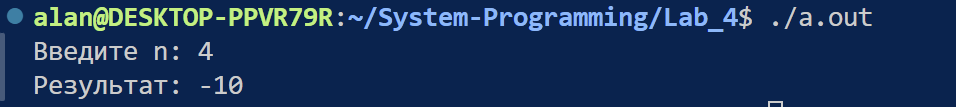

In [ ]:
#include <stdio.h>
#include <stdlib.h>

int main() {
    int n;

    printf("Введите n: ");
    scanf("%d", &n);

    if (n <= 0) {
        printf("n должно быть положительным числом\n");
        return 1;
    }

    long long sum = 0;

    for (int k = 1; k <= n; k++) {
        int sign;
        if ((k + 1) % 2 == 0) {
            sign = 1;
        } else {
            sign = -1;
        }

        long long term = sign * (long long)k * k;

        sum += term;

        printf("k=%d: (%d) × %d² = %d × %d = %lld\n",
               k, sign, k, sign, k*k, term);
    }

    printf("Результат: %lld\n", sum);

    return 0;
}


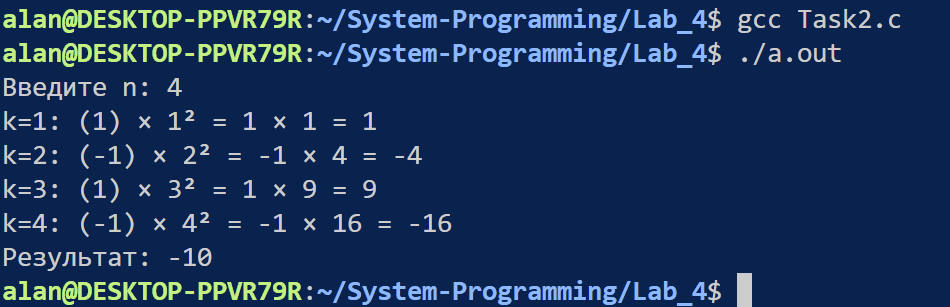

In [ ]:
format ELF64
public _start
public exit

include '/home/alan/System-Programming/help.asm'
include '/home/alan/System-Programming/func.asm'

section '.bss' writable
    buffer rb 256
    n dq 0
    sum dq 0

section '.text' executable
_start:
    mov rsi, buffer
    call input_keyboard

    call atoi

    add rax, 1
    mov [n], rax
    mov rcx, 0

    loop_start:
        mov rax, rcx
        mov rbx, rcx
        inc rbx
        imul rbx

        mov rbx, rcx
        imul rbx, 3
        inc rbx
        imul rbx

        mov rbx, rcx
        imul rbx, 3
        add rbx, 2
        imul rbx

        test rcx, 1
        jz even_k
        mov rbx, -1
        jmp sign_done
    even_k:
        mov rbx, 1

    sign_done:
        imul rbx

        add [sum], rax

        call print_int
        call new_line

        inc rcx
        cmp rcx, [n]
        jnz loop_start

    mov rax, [sum]

    call print_int
    call new_line

    call exit


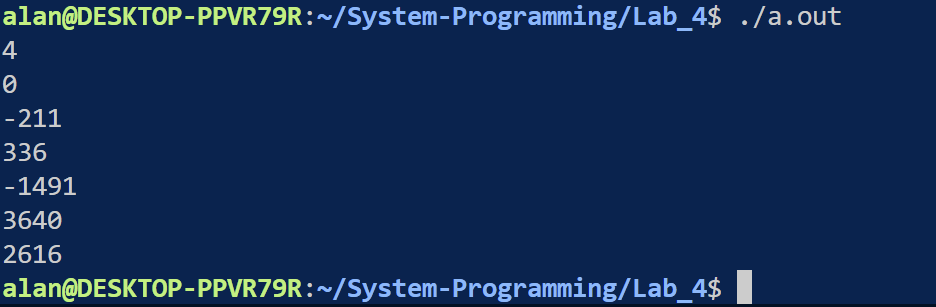

In [ ]:
#include <stdio.h>
#include <stdlib.h>

long long calculate_sum(int n) {
    long long sum = 0;

    for (int k = 1; k <= n; k++) {
        int sign = (k % 2 == 0) ? 1 : -1;

        long long term = (long long)k * (k + 1) * (3*k + 1) * (3*k + 2);

        sum += sign * term;
    }

    return sum;
}

int main() {
    int n;

    printf("Введите n: ");
    scanf("%d", &n);

    if (n <= 0) {
        printf("n должно быть положительным числом\n");
        return 1;
    }

    long long result = calculate_sum(n);
    printf("Результат: %lld\n", result);

    return 0;
}


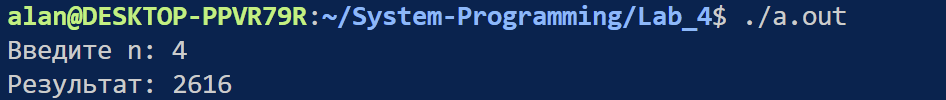

In [ ]:
format ELF64

public _start
public printMenu
public enterPassword
public exit
public printEnd
public printFail
public printAgain


section '.data' writable
    password db "qwerty123"
    msg rb 255
    menu db "Enter password: "
    endWord db "Successfully", 0xA
    fail db "Failure", 0xA
    again db "Try again", 0xA

section '.text' executable
_start:
    xor rbx, rbx
    .iter:
        xor rcx, rcx
        call printMenu
        call enterPassword
        inc rbx
        cmp rbx, 5
        je .iter_exit
        cmp rax, 10
        jne .iter_continue
        jmp .iter2

        .iter2:
            mov al, [msg + rcx]
            mov bl, [password + rcx]
            cmp al, bl
            jne .iter_continue
            inc rcx

            cmp rcx, 9
            jne .iter2

            jmp .success_exit

        .iter_exit:
            call printFail
            call exit

        .iter_continue:
            call printAgain
            jmp .iter


        .iter2_continue:
            cmp rcx, 9
            jne .iter2

        .success_exit:
            call printEnd
            call exit






printMenu:
    push rcx
    mov rax, 1
    mov rdi, 1
    mov rsi, menu
    mov rdx, 16
    syscall
    pop rcx
    ret

enterPassword:
    push rcx
    mov rax, 0
    mov rdi, 0
    mov rsi, msg
    mov rdx, 255
    syscall
    pop rcx
    ret

printEnd:
    push rcx
    mov rax, 1
    mov rdi, 1
    mov rsi, endWord
    mov rdx, 13
    syscall
    pop rcx
    ret

printFail:
    push rcx
    mov rax, 1
    mov rdi, 1
    mov rsi, fail
    mov rdx, 8
    syscall
    pop rcx
    ret

printAgain:
    push rcx
    mov rax, 1
    mov rdi, 1
    mov rsi, again
    mov rdx, 10
    syscall
    pop rcx
    ret

exit:
    mov rax, 60
    mov rdi, 0
    syscall


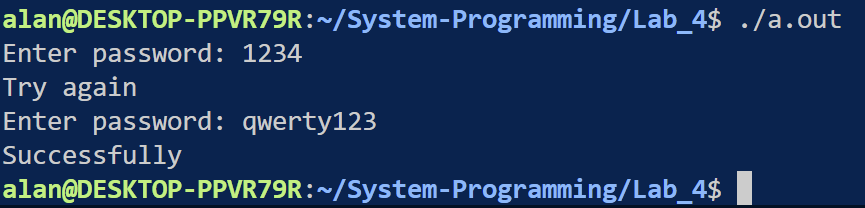

In [ ]:
#include <stdio.h>
#include <string.h>

int main() {
    const char correct_password[] = "qwerty123";
    char inputPassword[50];
    int attempts = 0;
    const int maxAttempts = 5;
    int authenticated = 0;



    while (attempts < maxAttempts) {
        printf("Введите пароль: ");
        scanf("%s", inputPassword);


        if (strcmp(inputPassword, correct_password) == 0) {
            authenticated = 1;
            break;
        } else {
            attempts++;
            printf("Неверный пароль! ");

            if (attempts < maxAttempts) {
                printf("Осталось попыток: %d\n", maxAttempts - attempts);
            } else {
                printf("Попытки исчерпаны.\n");
            }
        }
    }

    if (authenticated) {
        printf("Вход\n");
    } else {
        printf("Неудача\n");
    }

    return 0;
}


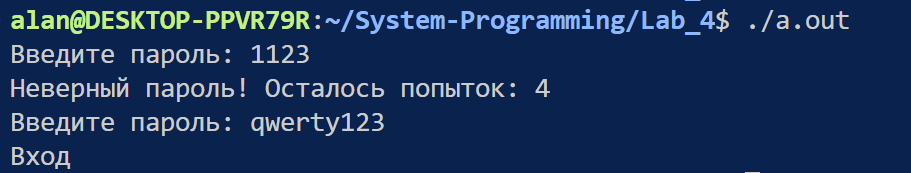